# Validation of method

### Table of contents

1. [**Heteroscedastic GP**](#hetero)
3. [**Renewal process GP**](#renewal)
4. [**GP-GLM**](#gpglm)

##### Description
This notebook contains code for:
- Compare LVM, LVM + self-coupling, full GLM coupling to explain correlations
- Neural data is synthetic Gaussian place field population with low dimensional correlations and real place field data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
#jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../lib/filters/FIR.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Count processes

In [12]:
neurons = 3
tbin = 0.01  # s

count_type = 'nb'

if count_type == 'p':
    count = lib.likelihoods.factorized.Poisson(
        neurons,
        tbin,
    )
    
elif count_type == 'zip':
    alpha = np.linspace(0.0, 0.95, neurons)
    count = lib.likelihoods.factorized.ZeroInflatedPoisson(
        neurons,
        tbin,
        alpha,
    )
    
elif count_type == 'nb':
    r_inv = np.linspace(0.0, 1.5, neurons)
    count = lib.likelihoods.factorized.NegativeBinomial(
        neurons,
        tbin,
        r_inv,
    )
    
elif count_type == 'cmp':
    nu = np.linspace(0.5, 1.5, neurons)
    count = lib.likelihoods.factorized.ConwayMaxwellPoisson(
        neurons,
        tbin,
        nu,
    )

In [13]:
y = jnp.arange(0, 20)[:, None].repeat(neurons, axis=1)
f = jnp.linspace(6, 6, neurons)

log_p_y = jax.vmap(count.log_likelihood, (None, 0), 0)(f, y)

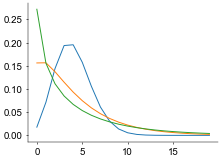

In [14]:
plt.plot(np.exp(log_p_y))

In [143]:
jnp.exp(f)

DeviceArray([403.4288, 403.4288, 403.4288], dtype=float32)

<a id='glm'></a>
## GLM

In [47]:
filter_length = 100

flt_type = 'rcb'
if flt_type == 'sigmoid':
    alpha = np.ones((2, 2))
    beta = np.ones((2, 2))
    tau = 10*np.ones((2, 2))

    flt = lib.filters.FIR.SigmoidRefractory(
        alpha,
        beta,
        tau,
        filter_length,
    )
    
elif flt_type == 'rcb':
    
    a = np.ones((2, 5, 5))
    c = np.ones((2, 5, 5))
    w_h = np.zeros((2, 5, 5)) + np.random.randn(2, 5, 5)
    phi_h = np.ones((2, 5, 5))
        
    flt = lib.filters.FIR.RaisedCosineBumps(
        a,
        c,
        w_h,
        phi_h, 
        filter_length,
    )

In [48]:
prng_state = jr.PRNGKey(123)

h, KL = flt.compute_filter(prng_state)

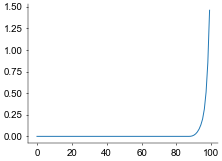

In [51]:
plt.plot(h[:, 2, 3])

in shapes: (1, 200, 2) (3, 2, 2)
ConvDimensionNumbers(lhs_spec=(0, 2, 1), rhs_spec=(2, 1, 0), out_spec=(0, 2, 1))
out shape:  (1, 200, 2)


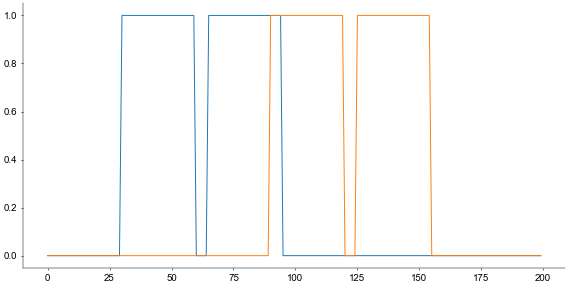

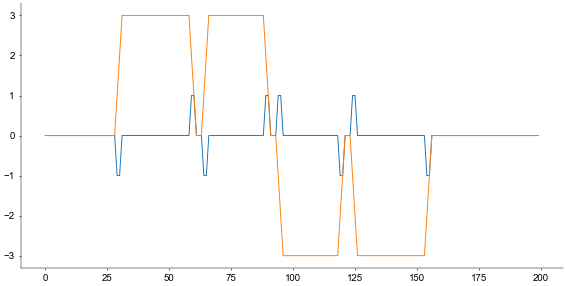

In [10]:
from jax import lax

# 1D kernel - WIO layout
kernel = jnp.array([[[1, 0, -1], [-1,  0,  1]], 
                    [[1, 1,  1], [-1, -1, -1]]], 
                    dtype=jnp.float32).transpose([2,1,0])
# 1D data - NWC layout
data = np.zeros((1, 200, 2), dtype=jnp.float32)
for i in range(2):
  for k in range(2):
      x = 35*i + 30 + 60*k
      data[0, x:x+30, k] = 1.0

print("in shapes:", data.shape, kernel.shape)

plt.figure(figsize=(10,5))
plt.plot(data[0]);
dn = lax.conv_dimension_numbers(data.shape, kernel.shape,
                                ('NWC', 'WIO', 'NWC'))
print(dn)

out = lax.conv_general_dilated(data,   # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (1,),   # window strides
                               'SAME', # padding mode
                               (1,),   # lhs/image dilation
                               (1,),   # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape)
plt.figure(figsize=(10,5))
plt.plot(out[0]);

In [66]:
jax.lax.conv_general_dilated_patches

<function jax._src.lax.other.conv_general_dilated_patches(lhs: jax._src.basearray.Array, filter_shape: Sequence[int], window_strides: Sequence[int], padding: Union[str, Sequence[Tuple[int, int]]], lhs_dilation: Optional[Sequence[int]] = None, rhs_dilation: Optional[Sequence[int]] = None, dimension_numbers: Union[NoneType, jax._src.lax.convolution.ConvDimensionNumbers, Tuple[str, str, str]] = None, precision: Optional[jax._src.lax.lax.Precision] = None, preferred_element_type: Optional[Any] = None) -> jax._src.basearray.Array>

In [73]:
import jax.numpy as jnp

#dev = jax.local_devices()[0]
# jax.device_put()#, device=dev)

ftmap = jnp.ones((1, 384, 384, 256), dtype=jnp.bfloat16)
W = 5
stride = (4, 4)
padding = (W // 2, W // 2)
jax.lax.conv_general_dilated_patches(ftmap, filter_shape=(5, 5), window_strides=stride, padding=padding)

ValueError: padding argument to conv_general_dilated should be a string or a sequence of (low, high) pairs, got (2, 2)